Здесь я хочу поделиться с вами некоторыми лайфхаками для Python и Matplotlib, которые помогут строить красивые и продуманные графики, пригодные для демонстрации другим людям. Данный пост написан в формате Jupyter Notebook, и по ссылке "Источник" под заголовком можно его скачать.

<!-- TEASER_END -->

### Ссылки

- Исходник: <https://blog.alicorn.tk/posts/best-plot-mpl.ipynb>
- sample.fits: <https://blog.alicorn.tk/other/sample.fits>
- cc-sample.fits: <https://blog.alicorn.tk/other/cc-sample.fits>

## Импортируем нужные библиотеки и подгрузим данные

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.animation import FFMpegWriter
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

# библиотека для работы с астрономическим форматом FITS
import astropy.io.fits as fits

# для вытаскивания дат из FITS-ов
import dateutil, datetime

In [2]:
# Этот код нужен, чтобы подгрузить инфу для примеров

def timestamp_from_header(header):
    timeref_str = header["DATE-OBS"] + " " + header["CRVAL1"] + " +0000"
    return int(dateutil.parser.parse(timeref_str).\
        replace(tzinfo=datetime.timezone.utc).timestamp())

def pretty_dates(timestamps):
    return [datetime.datetime.utcfromtimestamp(ts) for ts in timestamps]

def get_correlation_curve(fname):
    fitsdata = fits.open(fname)
    header = fitsdata[0].header
    data = fitsdata[0].data

    ts_default = timestamp_from_header(header)

    timestamps = np.arange(len(data)) + ts_default
    return {"data": data, "unix": timestamps, "times": pretty_dates(timestamps)}

pic = fits.getdata("../sample.fits")
cc = get_correlation_curve("../cc-sample.fits")

## Построим пробный график

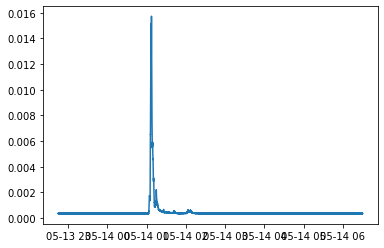

In [3]:
plt.plot(cc["times"], cc["data"])

Как видим, изначально график получился не очень. Даты по оси X наезжают друг на друга, сам график маленький, да и толком ничего не видно. Надо это исправить

## Настроим размер холста, шрифты и фигуру

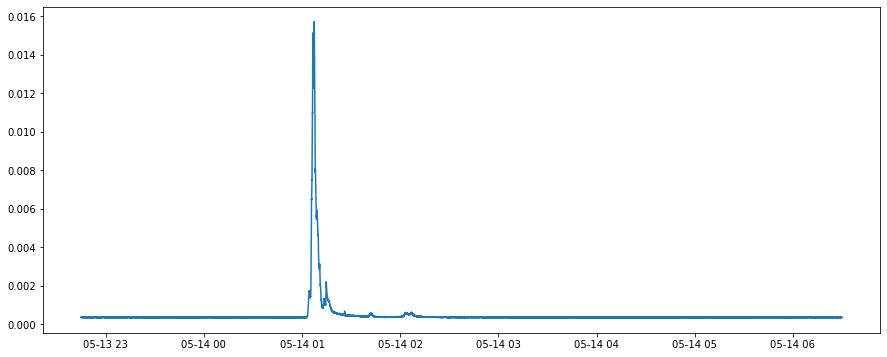

In [4]:
plt.figure(figsize = (15, 6))
plt.plot(cc["times"], cc["data"])

### Гораздо лучше, а теперь попробуем сделать

* Отображение дат по оси X покрасивее
* Покрупнее шрифт
* Добавим сетку, заголовки, поменяем цвет

<ipython-input-5-a3d05b51e81e>:13: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(nbins=15) # ставим более густую сетку


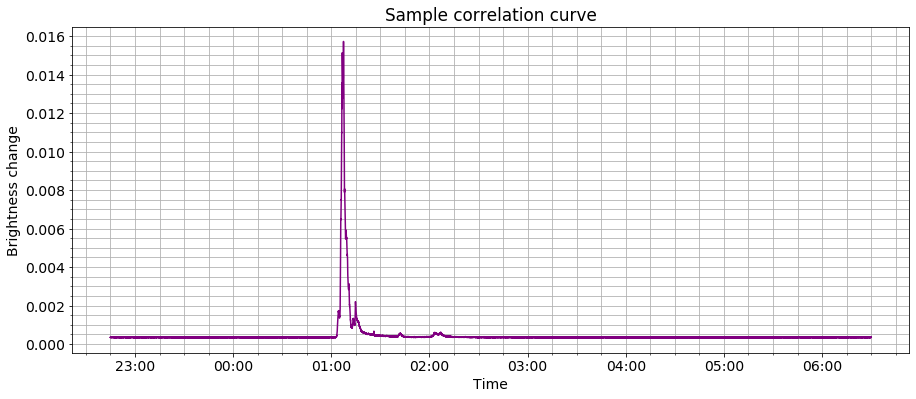

In [5]:
font = {'weight': 'normal', 'size': 14}
mpl.rc('font', **font)

plt.figure(figsize = (15, 6))

plt.title("Sample correlation curve")
plt.xlabel("Time")
plt.ylabel("Brightness change")

plt.plot(cc["times"], cc["data"], color = "purple")
plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))

plt.locator_params(nbins=15) # ставим более густую сетку
plt.grid(True, which="both")
plt.minorticks_on()

### Всё равно что-то не то

Давайте сделаем **второй график**, на котором будет то же самое, только в масштабе, заодно можно будет увидеть вспышку

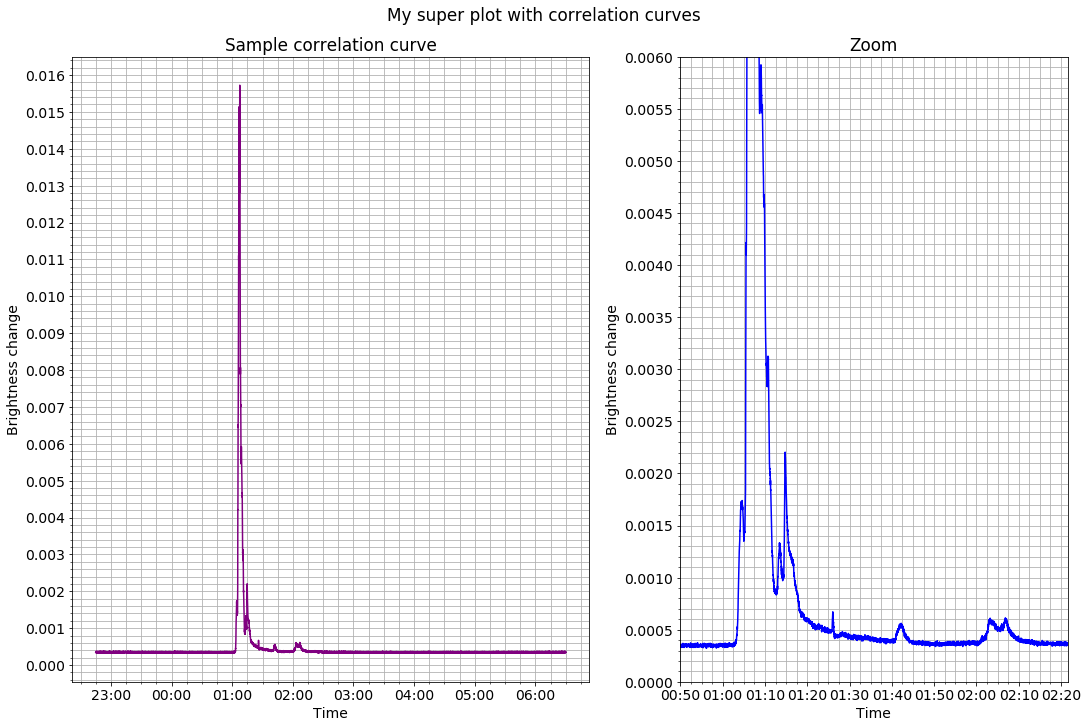

In [6]:
# настройки шрифтов сохраняются, поэтому делать mpl.rc снова не требуется

# 2 - строки, 1 - столбцы; массив ax - это одномерный массив с графиками
# constrained_layout требуется, чтобы сами графики и их заголовки располагались плотнее
# width_ratios - пропорции по размеру
fig, ax = plt.subplots(1, 2, figsize = (15, 10), gridspec_kw={'width_ratios': [4, 3]}, constrained_layout = True)

top, bottom = ax
fig.suptitle("My super plot with correlation curves")

top.set_title("Sample correlation curve")
bottom.set_title("Zoom")

for axis in ax:
    axis.set_xlabel("Time")
    axis.set_ylabel("Brightness change")
    axis.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))

    axis.locator_params("y", nbins=20)
    axis.locator_params("x", nbins=4)
    # или просто axis.locator_params(nbins=10)
    axis.grid(True, which="both")
    axis.minorticks_on()

top.plot(cc["times"], cc["data"], color = "purple")
bottom.plot(cc["times"], cc["data"], color = "blue")

bottom.set_ylim(0, 0.006)
bottom.set_xlim(cc["times"][7500], cc["times"][13000]);

## Картиночки

Очень многие данные представляют собой картинки. Давайте загрузим картинку Солнца с радиотелескопа и попробуем там что-нибудь рассмотреть

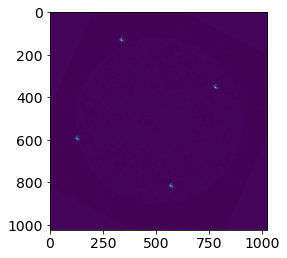

In [7]:
plt.imshow(pic)

### Уупс, что-то пошло не так

Совсем ничего не видно! Надо исправить это, сжав яркостный диапазон данных с помощью кубического корня, `np.cbrt`

Изображения в астрономии принято считать не по экранным координатам (где пиксели идут сверху вниз), а по естественным, где снизу вверх. Для этого при построении нужно указать `origin="low"`

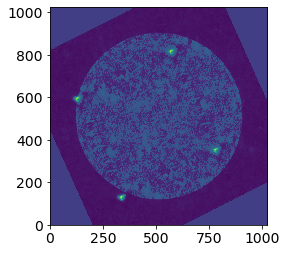

In [8]:
plt.imshow(np.cbrt(pic), origin="low");

Теперь можно сменить тему оформления и вывести на экран нужный диапазон яркостей. Параметры vmin и vmax также работают при построении картинок.

Справка по темам (они же цветовые схемы или cmap) в matplotlib: <https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html>

Изменение расположения colorbar (make_axes_locatable): <https://matplotlib.org/stable/gallery/axes_grid1/demo_colorbar_with_axes_divider.html>

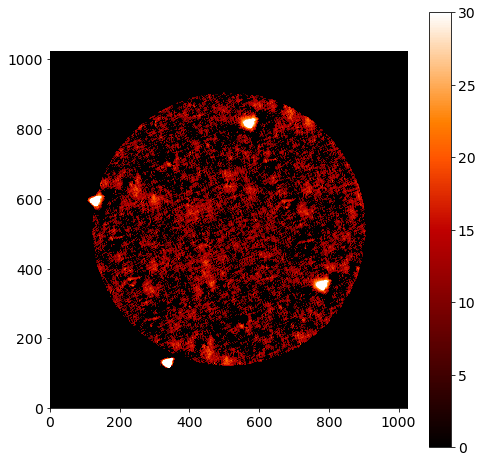

In [9]:
plt.rcParams['image.cmap'] = 'gist_heat'

plt.figure(figsize=(8, 8))
plt.imshow(np.cbrt(pic), vmin=0, vmax=30, origin="low")
plt.colorbar();

## Работа с сеткой

Иногда требуется строить большое количество графиков или картинок одновременно, из-за чего удобно расположить их в виде сетки. Объект axes с графиками уже становится двумерным массивом. Попробуем сделать демонстрацию разных тем оформления для matplotlib и применить их к картинке с Солнцем

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:3040: RuntimeWarning: overflow encountered in exp
  return exp(x) * _chbevl(32.0/x - 2.0, _i0B) / sqrt(x)


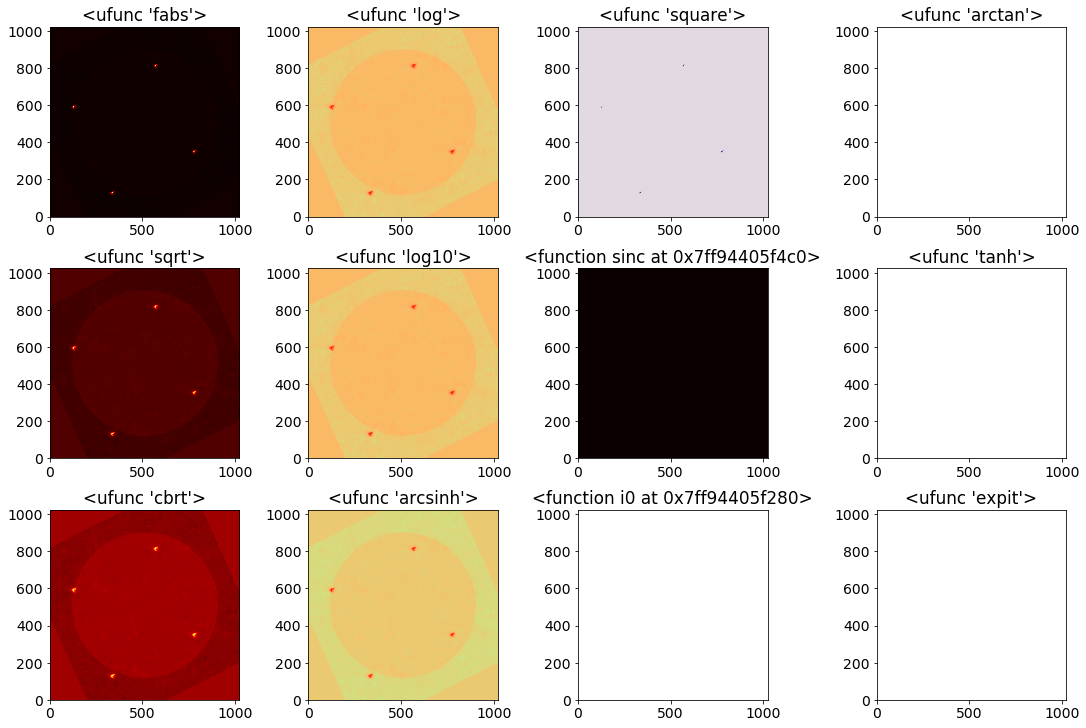

In [10]:
import scipy.special

fig, axes = plt.subplots(3, 4, figsize = (15, 10), constrained_layout = True)
ways = [np.fabs, np.sqrt, np.cbrt, np.log, np.log10, np.arcsinh, np.square, np.sinc, np.i0, np.arctan, np.tanh, scipy.special.expit]
cmaps = ["hot", "hot", "hot", "rainbow", "rainbow", "rainbow", "twilight", "hot", "hot", "hot", "hot", "hot"]

pic2 = pic - np.min(pic) + 0.1

c = 0 # столбец
for column in axes:
    r = 0 # строка
    for ax in column:
        ax.set_title(str(ways[r*len(axes) + c]))
        ax.imshow(ways[r*len(axes) + c](pic2), origin="low", cmap=cmaps[r*len(axes) + c])
        r += 1
    c += 1

Как видно, не все темы одинаково хорошо подходят для Солнца. Тема `hot` в случаях справа оказалась настолько hot, что не выдержала яркостного диапазона и вывалилась в пустой белый цвет. Поэтому нужно аккуратно подбирать способ подгонки изображения (иногда применяя разные способы) и пробовать разные темы под свой вкус. Я обычно пользуюсь подстройкой под кубический корень и темой `gist_heat`. А ещё в расовом понячьем matplotlib есть темы `twilight` и `rainbow` :3

Кроме `subplots` есть и другие способы делать сложные графики, размещая их вместе. Например, [Gridspec](https://matplotlib.org/3.1.1/tutorials/intermediate/gridspec.html). В рамках моего поста разбирать его, может быть, имеет мало смысла, но не упомянуть нельзя.

## Другой способ итерации по нескольким осям

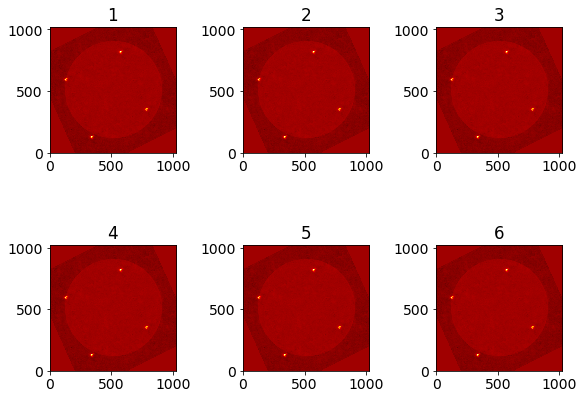

In [11]:
fig, axes = plt.subplots(2, 3, figsize = (8, 6), constrained_layout = True)

for i, ax in zip(range(len(axes.flat)), axes.flat):
    ax.imshow(np.cbrt(pic2), origin="low", cmap="hot")
    ax.set_title(str(i+1))

## Анализ социальных взаимодействий и обнимашки

Теперь давайте перейдём с нашего родного светила к тому, что поймут многие - к личным данным. Расскажу по секрету всему свету: у меня есть один хороший знакомый человек, с которым мы встречаемся ради обнимашек. Да, только ради обнимашек, никакого интима. Кто не в курсе, я очень помешан на обнимашках, ведь это один из немногих видов времяпрепровождения, который меня успокаивает и улучшает самочувствие. Ещё один - это программирование.

Свои даты встреч с тем человеком я записываю (да, этот датасет настоящий!), и имея данные, могу проанализировать частоты обнимашек и, следовательно, своё эмоциональное состояние в течение года. Сами встречи для простоты помечены единичкой. Загрузим датасет с помощью библиотеки для анализа данных `pandas` и построим график:

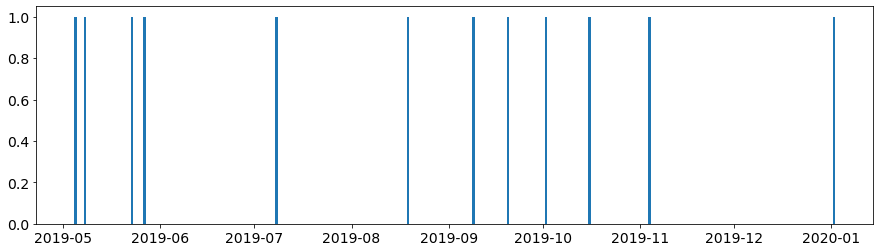

In [12]:
import pandas as pd
from io import StringIO

# Нужно, чтобы даты формата pandas отображались в графиках
pd.plotting.register_matplotlib_converters()

DATA = StringIO("""
times freq
05.05.2019 1
08.05.2019 1
23.05.2019 1
27.05.2019 1
08.07.2019 1
19.08.2019 1
09.09.2019 1
20.09.2019 1
02.10.2019 1
16.10.2019 1
04.11.2019 1
02.01.2020 1
""")

# Важно! dayfirst=True нужен, чтобы pandas не путал месяц и день в дате,
# то есть соблюдал прямой порядок dd.mm.yyyy

dates = pd.read_csv(DATA, sep=" ", parse_dates=["times"], dayfirst=True)
dates.set_index("times")
plt.figure(figsize=(15, 4))
plt.bar(dates.times, dates.freq);

Получилось наглядно, но далеко от идеала.

### Выводим график в виде календаря

Можно попробовать посмотреть на частоты обнимашковстреч по-другому, например, в виде Github-style диаграммы. Для этого воспользуемся уже готовой библиотекой [Calplot](https://github.com/tomkwok/calplot), которая сама взаимодействует с matplotlib под капотом

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


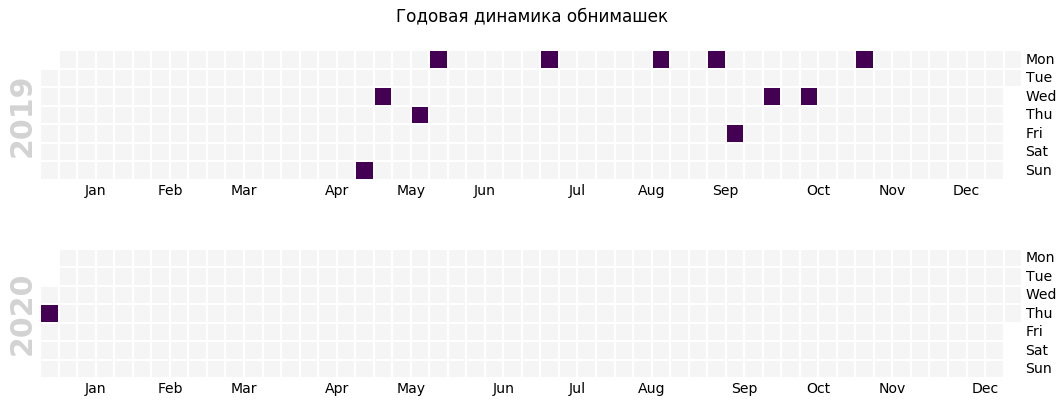

In [13]:
import calplot

grid = pd.Series(dates.freq.values, index=dates.times)
calplot.calplot(grid, figsize=(15, 6), suptitle="Годовая динамика обнимашек")
plt.show();

### Ресэмплинг

Библиотека Pandas поддерживает переформатирование набора данных путём изменения количества точек. Называется эта тема resampling, и Google Translate переводит его на русский язык несколькими способами:

- передискретизация
- рес(э/е)мплинг
- ресэмплирование
- повторная выборка

Определение [из Википедии](https://ru.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%B4%D0%B8%D1%81%D0%BA%D1%80%D0%B5%D1%82%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F):

> Передискретиза́ция (англ. resampling) в обработке сигналов — изменение частоты дискретизации дискретного (чаще всего цифрового) сигнала. Алгоритмы передискретизации широко применяются при обработке звуковых сигналов, радиосигналов и изображений (передискретизация растрового изображения — это изменение его разрешения в пикселах).

> Отсчёты сигнала, соответствующие новой частоте дискретизации, вычисляются по уже имеющимся отсчётам и не содержат новой информации.

### Применительно к обнимашкам

Предположим, для того чтобы не скатиться в дерьмовое настроение, мне требуется один сеанс обнимашек в неделю (на самом деле в 2-3 дня, а не неделю, но здесь чисто для примера). Тогда для каждого дня мы можем посчитать, а сколько же обнимашек было в предыдущие пару дней. И если это число _больше или равно единице_, то можно считать, что моё настроение в данный период хорошее.

Такое число можно считать некоторой приблизительной мерой настроения и высчитывать для разных периодов времени. В анализе данных это будет ресэмплинг с суммированием. Чем больше период суммирования, тем более гладкие получаются графики, но при этом меньше точек

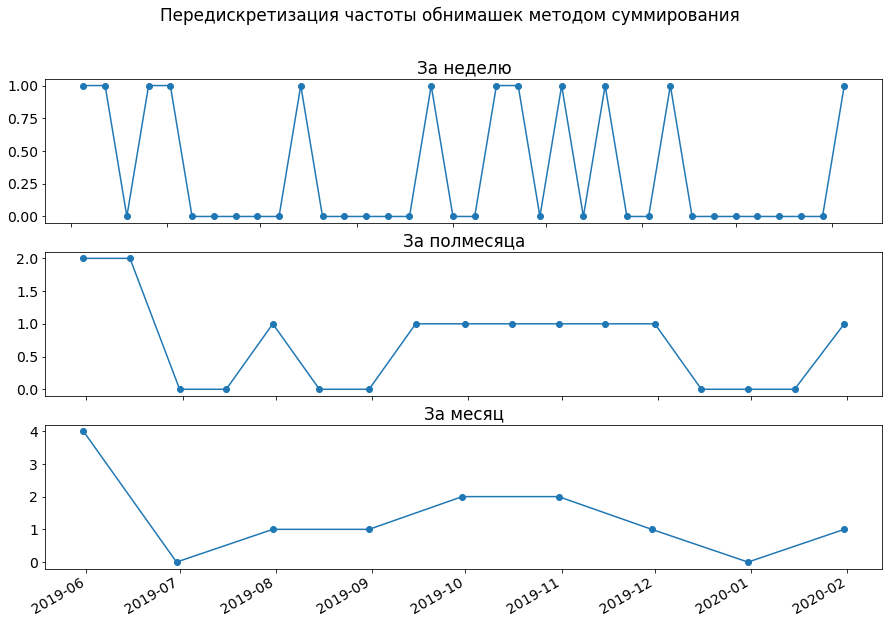

In [14]:
resampled_data = [grid.resample(freq).sum() for freq in ["w", "sm", "m"]]
titles = ["За неделю", "За полмесяца", "За месяц"]

fig, axes = plt.subplots(3, 1, figsize = (15, 10))
fig.autofmt_xdate()
fig.suptitle("Передискретизация частоты обнимашек методом суммирования")

for i in range(0, 3):
    axes[i].plot(resampled_data[i], "-o")
    axes[i].set_title(titles[i])

Как видно из графиков, в среднем у меня получается около 0-1 обнимашек в неделю и примерно по 1 обнимашке в месяц. Это... печально. <font color="grey">Если ты это читаешь и тебе стыдно, то прости =(</font>

### Справка по ресэмплингу в Pandas

<https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html>

<https://www.geeksforgeeks.org/python-pandas-dataframe-resample/>

## Сохраняем данные в разные форматы

В предыдущих постах я уже кое-что из этого приводил, но кратко продублирую здесь для удобства, чтобы не ходить и не искать

#### Сохранение в картинку

```python
plt.savefig("pic.png", dpi=100, bbox_inches = "tight")
```

#### Сохранение в видео

```python
from matplotlib.animation import FFMpegWriter
writer = FFMpegWriter(fps=3, extra_args=['-vcodec', 'libx264'])

with writer.saving(fig, path, dpi=110):
    for pic in pics:
        # plot your picture inside the figure
        writer.grab_frame()
```

#### Сохранение в PDF по графику на каждую страницу

```python
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages("yourfile.pdf")

for pic in pics:
    # plot your data inside the figure object
    pp.savefig()

pp.close()
```

## И напоследок

Готовые примеры красивых графиков в matplotlib и не только: <https://www.python-graph-gallery.com>

Data to Viz или как сделать визуализацию данных более наглядной: <https://www.data-to-viz.com/>

Этот пост будет в дальнейшем пополняться и изменяться, чтобы все нужные штуки сразу были под рукой.